In [1]:
import os 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np 
from tensorflow import keras
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageFile
from PIL import ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow as tf

input_dir = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image2'
target_dir = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_mask3'
img_size = (320,320)
num_classes = 7
batch_size = 32

input_img_paths = sorted([os.path.join(input_dir,fname)
                         for fname in os.listdir(input_dir)
                         if fname.endswith('.jpg')])

target_img_paths = sorted([os.path.join(target_dir,fname)
                         for fname in os.listdir(target_dir)
                         if fname.endswith('.png') and not fname.startswith('.')])

C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class SkinDiseaseDataset(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img_to_array(img) / 255.  # input normalization
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            img = img_to_array(img)  # Removed normalization here
            y[j] = img

        return x, y

In [3]:
import random 
val_samples = 800
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = SkinDiseaseDataset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SkinDiseaseDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [4]:
x, y = train_gen[0]  # 첫 번째 배치 가져오기
print(x.shape, y.shape)
print(np.min(x), np.max(x), np.min(y), np.max(y))  # 데이터 범위 확인

(32, 320, 320, 3) (32, 320, 320, 1)
0.0 1.0 0 6


In [5]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3180334, 1: 1712, 2: 3354, 3: 21666, 4: 14028, 5: 48661, 6: 7045}


In [6]:
from tensorflow.keras import layers 

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x 
    
    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
        
    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x 
        
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [7]:
model = get_model(img_size, num_classes)
# model.summary()

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=1e-6), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=RMSprop(learning_rate=1e-6), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint('Unet_segmentation_1.h5', save_best_only=True)]

epochs = 100

In [ ]:
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/100
162/162 [==============================] - 163s 950ms/step - loss: 3.2018 - accuracy: 0.2181 - val_loss: 2.1268 - val_accuracy: 0.0088
Epoch 2/100


C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


162/162 [==============================] - 154s 950ms/step - loss: 1.4484 - accuracy: 0.5471 - val_loss: 1.3226 - val_accuracy: 0.3997
Epoch 3/100
162/162 [==============================] - 154s 946ms/step - loss: 0.5675 - accuracy: 0.8543 - val_loss: 0.4390 - val_accuracy: 0.9612
Epoch 4/100
162/162 [==============================] - 154s 949ms/step - loss: 0.2409 - accuracy: 0.9700 - val_loss: 0.1846 - val_accuracy: 0.9929
Epoch 5/100
162/162 [==============================] - 153s 942ms/step - loss: 0.1614 - accuracy: 0.9927 - val_loss: 0.1529 - val_accuracy: 0.9956
Epoch 6/100
162/162 [==============================] - 156s 960ms/step - loss: 0.1455 - accuracy: 0.9962 - val_loss: 0.1499 - val_accuracy: 0.9958
Epoch 7/100
162/162 [==============================] - 155s 958ms/step - loss: 0.1397 - accuracy: 0.9967 - val_loss: 0.1465 - val_accuracy: 0.9964
Epoch 8/100
162/162 [==============================] - 154s 952ms/step - loss: 0.1360 - accuracy: 0.9969 - val_loss: 0.1432 - val_

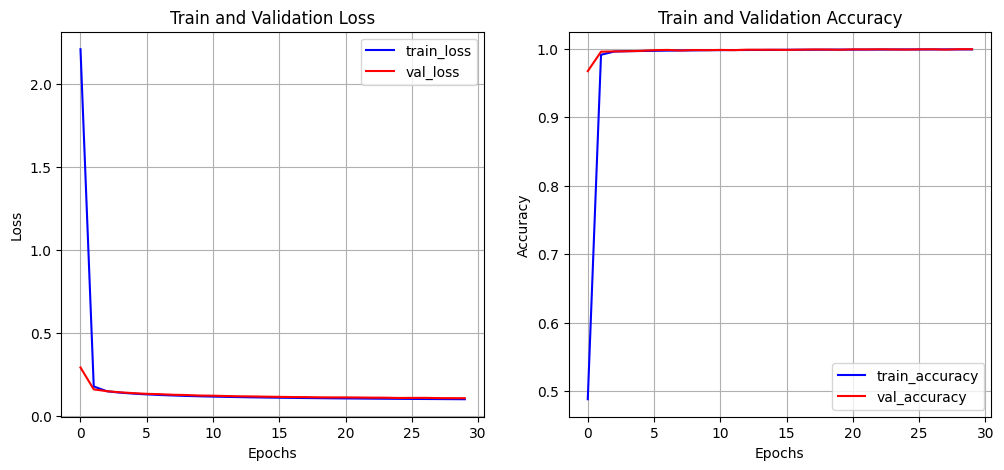

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

ax2 = fig.add_subplot(1,2,2)
ax2.plot(accuracy, color='blue', label='train_accuracy')
ax2.plot(val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

some_input, _ = val_gen[0]
# 예측 수행
predictions = model.predict(some_input)

# 가장 높은 확률을 가진 클래스 선택
predicted_classes = np.argmax(predictions, axis=-1)

# 원래의 클래스 레이블로 매핑
original_classes = predicted_classes 

# 사용자 정의 컬러맵 생성
cmap = ListedColormap( ['black','red', 'green', 'blue', 'yellow', 'purple', 'cyan'])

# 이미지 표시
plt.imshow(original_classes[6], cmap=cmap)
plt.show()

# 이미지 추론 방법 1

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np

# 사용자 정의 컬러 맵핑
COLOR_DICT = {
    0: [0, 0, 0],      # 검정색으로 배경을 표시
    1: [255, 0, 0],    # 클래스 1을 빨간색으로 표시
    2: [0, 255, 0],    # 클래스 2를 초록색으로 표시
    3: [0, 0, 255],    # 클래스 3을 파란색으로 표시
    4: [255, 255, 0],  # 클래스 4를 노란색으로 표시
    5: [0, 255, 255],  # 클래스 5를 시안색으로 표시
    6: [255, 0, 255],  # 클래스 6을 마젠타색으로 표시
}

# 모델로 예측 수행
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask_rgb = np.zeros((*mask.shape, 3))  # Create an empty RGB image
    for class_idx, color in COLOR_DICT.items():
        mask_rgb[mask == class_idx] = color  # Set the RGB values for each class
    return mask_rgb
    
i = 1

fig, ax = plt.subplots(1, 3, figsize=(10, 10))

# Original Image
ax[0].imshow(load_img(val_input_img_paths[i], target_size=(320, 320)))  # Resize to 256x256
ax[0].set_title('Original Image')

# Mask Image
mask = np.array(load_img(val_target_img_paths[i], target_size=(320, 320), color_mode='grayscale'))  # grayscale로 로드
mask_rgb = np.zeros((*mask.shape, 3))  # Create an empty RGB image
for class_idx, color in COLOR_DICT.items():
    mask_rgb[mask == class_idx] = color  # Set the RGB values for each class
ax[1].imshow(mask_rgb.astype(int))  # Ensure that the values are integers
ax[1].set_title('Mask Image')

# Predicted Mask
ax[2].imshow(display_mask(i))
ax[2].set_title('Predicted Mask')

plt.show()

In [ ]:
def pixel_accuracy(y_true, y_pred):
    correct_pixels = tf.equal(y_true, y_pred)
    pixel_accuracy = tf.reduce_mean(tf.cast(correct_pixels, tf.float32))
    return pixel_accuracy

In [ ]:
def mean_accuracy(y_true, y_pred, num_classes):
    class_accuracies = []
    for i in range(num_classes):
        correct_pixels = tf.equal(y_true, i) & tf.equal(y_pred, i)
        class_accuracy = tf.reduce_mean(tf.cast(correct_pixels, tf.float32))
        class_accuracies.append(class_accuracy)
    mean_accuracy = tf.reduce_mean(class_accuracies)
    return mean_accuracy


In [ ]:
def f1_score(y_true, y_pred, num_classes):
    f1_scores = []
    for i in range(num_classes):
        true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, i) & tf.equal(y_pred, i), tf.float32))
        false_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, i) & tf.not_equal(y_pred, i), tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(tf.not_equal(y_true, i) & tf.equal(y_pred, i), tf.float32))

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f1 = 2 * ((precision * recall) / (precision + recall))
        f1_scores.append(f1)

    return tf.reduce_mean(f1_scores)


In [ ]:
# 평가 데이터 로드
x_val, y_val = val_gen.__getitem__(0)

# 모델로 예측 수행
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=-1)

# 실제 결과를 클래스로 변환
y_true = np.argmax(y_val, axis=-1)

# 평가 지표 계산
pixel_acc = pixel_accuracy(y_true, y_pred)
mean_acc = mean_accuracy(y_true, y_pred, num_classes)
f1 = f1_score(y_true, y_pred, num_classes)

print('Pixel Accuracy:', pixel_acc)
print('Mean Accuracy:', mean_acc)
print('F1 Score:', f1)